Device: cuda


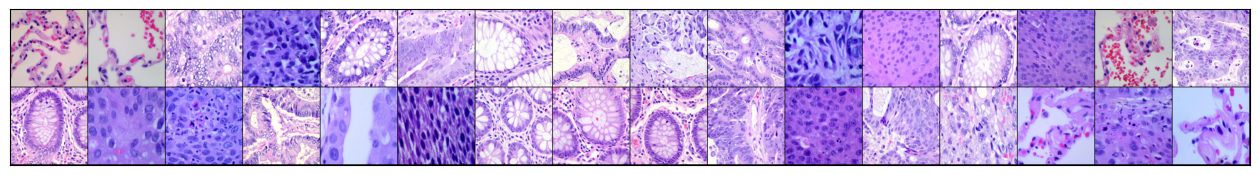

Testing DataLoader...
Loaded batch: 0
Loaded batch: 1
Loaded batch: 2
Done.


In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn.functional as F

import torchvision.transforms as transforms
import os
import torch.nn as nn

from PIL import Image
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn.functional as F
import os
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data.dataloader import DataLoader 





#Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print("Device:",device)

#to formate the images in dataset 
class LungColonDataset(Dataset):
    def __init__(self, df, img_size=(224, 224)):
        self.df = df.reset_index(drop=True)  # Reset index so row access works
        self.img_size = img_size
        self.transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        # Create label to index mapping
        self.label_to_idx = {label: idx for idx, label in enumerate(self.df['labels'].unique())}
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fpath = row['filepaths']
        label_name = row['labels']
        
        # Load image
        image = Image.open(fpath).convert('RGB')
        image = self.transform(image)
        
        # Encode label as integer
        label = self.label_to_idx[label_name]
        
        return image, label
    

data_dir = 'lungcolon'

file_paths = []
labels = []

label_map = {
    'colon_aca': 'Colon Adenocarcinoma',
    'colon_n':   'Colon Benign Tissue',
    'lung_aca':  'Lung Adenocarcinoma',
    'lung_n':    'Lung Benign Tissue',
    'lung_scc':  'Lung Squamous Cell Carcinoma'
}

for root, dirs, files in os.walk(data_dir):
    class_dir = os.path.basename(root)  # e.g. 'colon_aca'
    for fname in files:
        fpath = os.path.join(root, fname)
        file_paths.append(fpath)
        labels.append(label_map.get(class_dir, class_dir))

Fseries = pd.Series(file_paths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)



df 

strat = df['labels']
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 22, stratify= strat)

#split in validation and test,so 10 % each
strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 22, stratify= strat)



batch_size = 32
img_size = (224, 224)

train_dataset = LungColonDataset(train_df, img_size=img_size)
val_dataset = LungColonDataset(valid_df, img_size=img_size)



train_dB = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_dB = DataLoader(val_dataset, batch_size*2, shuffle=False, num_workers=0, pin_memory=True)

from torchvision.utils import make_grid

import matplotlib.pyplot as plt

def show_batch(df):
    """Plot images grid of single batch"""
    for images, labels in df:
        # Denormalize for display
        images = images * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        images = images + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        images = torch.clamp(images, 0, 1)

        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        plt.show()   # ensure 'fig' is used
        break
        
show_batch(train_dB)
print("Testing DataLoader...")
for i, (img, lbl) in enumerate(train_dB):
    print("Loaded batch:", i)
    if i == 2:
        break
print("Done.")



class NNCancer(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),

    nn.AdaptiveAvgPool2d((1,1)),  
    nn.Flatten(),
    nn.Linear(256, 5)             
)
    
    def forward(self, xb):
        return self.network(xb)


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
def evaluate(model, val_loader):
    model.eval()
    outputs = []
    for batch in val_loader:
        images, labels = batch 
        images,labels = images.to(device), labels.to(device)
        out = model(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        outputs.append({'val_loss': loss.detach(), 'val_acc': acc})
    
    
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    

from datetime import datetime


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)

    for epoch in range(epochs):
        start = datetime.now()
        model.train()
        train_losses = []

        for batch in train_loader:
            images, labels = batch
            
            images, labels = images.to(device), labels.to(device)
            out = model(images)
            loss = F.cross_entropy(out, labels)

            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()

        print(f"Epoch [{epoch}], train_loss: {result['train_loss']:.4f}, "
              f"val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")
        print(f"Time taken: {datetime.now() - start}")

        history.append(result)

    return history






In [35]:
model = NNCancer()
print(model) 

NNCancer(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): AdaptiveAvgPool2d(output_size=(1, 1))
    (16): Flatten(start_dim=1, end_dim=-1)
    (17): Linear(in_features=256, out_features=5, bias=True)
  )


In [36]:
model = model.to(device)
num_epochs = 3
opt_func = torch.optim.Adam
lr = 0.001
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dB, val_dB, opt_func)

KeyboardInterrupt: 

In [ ]:
history

import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn.functional as F

import torchvision.transforms as transforms
import os
import torch.nn as nn

from PIL import Image
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn.functional as F
import os
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data.dataloader import DataLoader 





#Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print("Device:",device)

#to formate the images in dataset 
class LungColonDataset(Dataset):
    def __init__(self, df, img_size=(224, 224)):
        self.df = df.reset_index(drop=True)  # Reset index so row access works
        self.img_size = img_size
        self.transform